In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
hawaii_sqlite = 'resources\\hawaii.sqlite'
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{hawaii_sqlite}")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

session = Session(engine)
inspector = inspect(engine)

# Exploratory Precipitation Analysis

In [20]:
# inspect the columns for columns names and dtypes
cols_station = inspector.get_columns('station')
for c in cols_station:
    print(c["name"], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [30]:
# display some data
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [10]:
# inspect the columns for columns names and dtypes
cols_measurement = inspector.get_columns('measurement')
for c in cols_measurement:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# display some data
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [12]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23',)

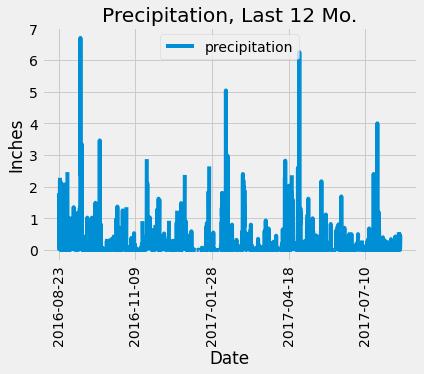

In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns=['date', 'precipitation'])

# df = df.set_index(['date'])

# Sort the dataframe by date
df = df.sort_values('date')


# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation, Last 12 Mo.')
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [29]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

# session.q(column, count(column) \
#     .group_by(station)\
#     .order_by(count(station))\
#     .desc for greatest to least\
#     .all for list return

session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station)\
    .desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
agg = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
session.query(*agg)\
    .filter(Measurement.station == 'USC00519281')\
    .all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

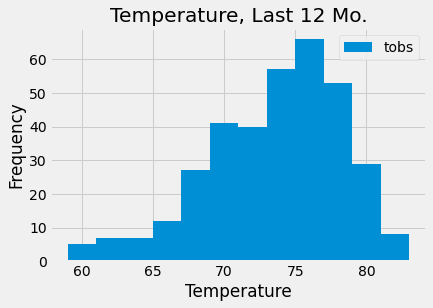

In [52]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# make formula to find the data
tobs_past_year = session.query(Measurement.tobs)\
    .filter(Measurement.station == 'USC00519281')\
    .filter(Measurement.date >= year_ago).all()

# create df from data
tobs_df = pd.DataFrame(tobs_past_year, columns=['tobs'])

# plot histogram now that there is a df for lib to reference
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

# make the bins
tobs_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.title('Temperature, Last 12 Mo.')
plt.show()

# Close session

In [19]:
# Close Session
session.close()